In [58]:
import copy as cp
import numpy as np
np.float = np.float_
np.object = np.object_
import matplotlib as m
import matplotlib.pyplot as plt
import copy as c
import pyemma 
import pyemma.msm as msm
import pyemma.plots as mplt
import pyemma.coordinates as coor
import pickle as pkl
import scipy.stats as sct
import scipy.optimize as sco
import gromacs as gmx
import pandas as pd
from itertools import combinations
import msmbuilder as msmb
import MDAnalysis as mda

In [2]:
import sys
sys.path.insert(0,'/home/jayakrishnak/hsp90/msahil/2_analysis/1_binding_trajs/3_msm/0_python_modules/')
from msm_analysis import analyze_msm_clusters as ana

In [3]:
data = np.load('../data_bp_mindist.npy', allow_pickle=True)
bp, mindist = [], []
for i in range(len(data)):
    bp.append(data[i][:,0])
    mindist.append(data[i][:,1])

In [4]:
for i in [50,100,300]: 
    globals()[f'cls_{i}'] = pkl.load(open('../clus{}_kmeans.pkl'.format(i), 'rb'))
    globals()[f'dtrj_{i}'] = np.load('../dtrajs_clus{}.npy'.format(i), allow_pickle=True)

In [5]:
msm_lags = [10,20,30,40,50,60]
mstates = [2,3,4,5]
mcolors = ['red', 'green', 'blue', 'orange', 'teal']

In [6]:
for i in mstates:
    globals()[f'cmap{i}'] = m.colors.LinearSegmentedColormap.from_list('cmap{}'.format(i), mcolors[:i], N=i)

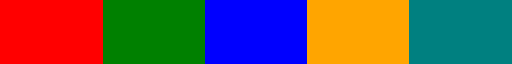

In [6]:
cmap5

(0.0, 1.0)

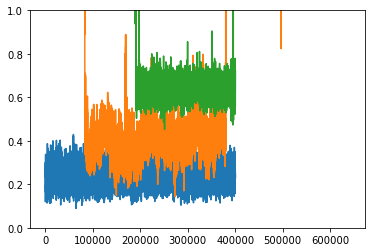

In [8]:
plt.plot(bp[0])
plt.plot(bp[4])
plt.plot(bp[5])
plt.ylim(0,1)

(0.1, 4.0)

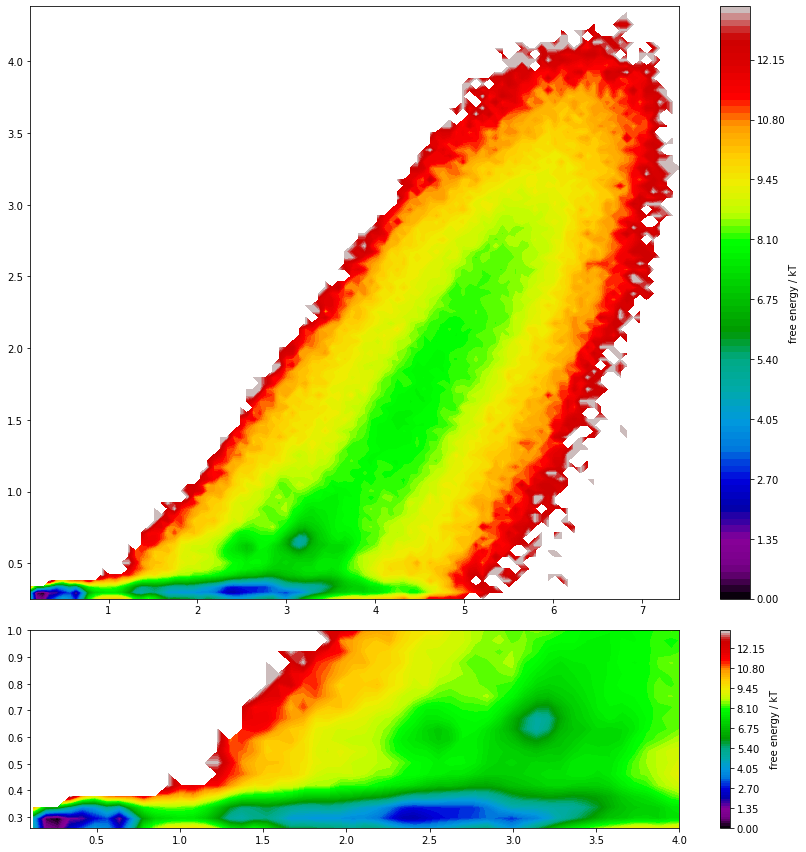

In [9]:
fig,ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(12,12))
plt.tight_layout()
mplt.plot_free_energy(np.concatenate((bp)), np.concatenate((mindist)), ax=ax[0])
mplt.plot_free_energy(np.concatenate((bp)), np.concatenate((mindist)), ax=ax[1])
ax[1].set_ylim(0.26,1)
ax[1].set_xlim(0.1,4)

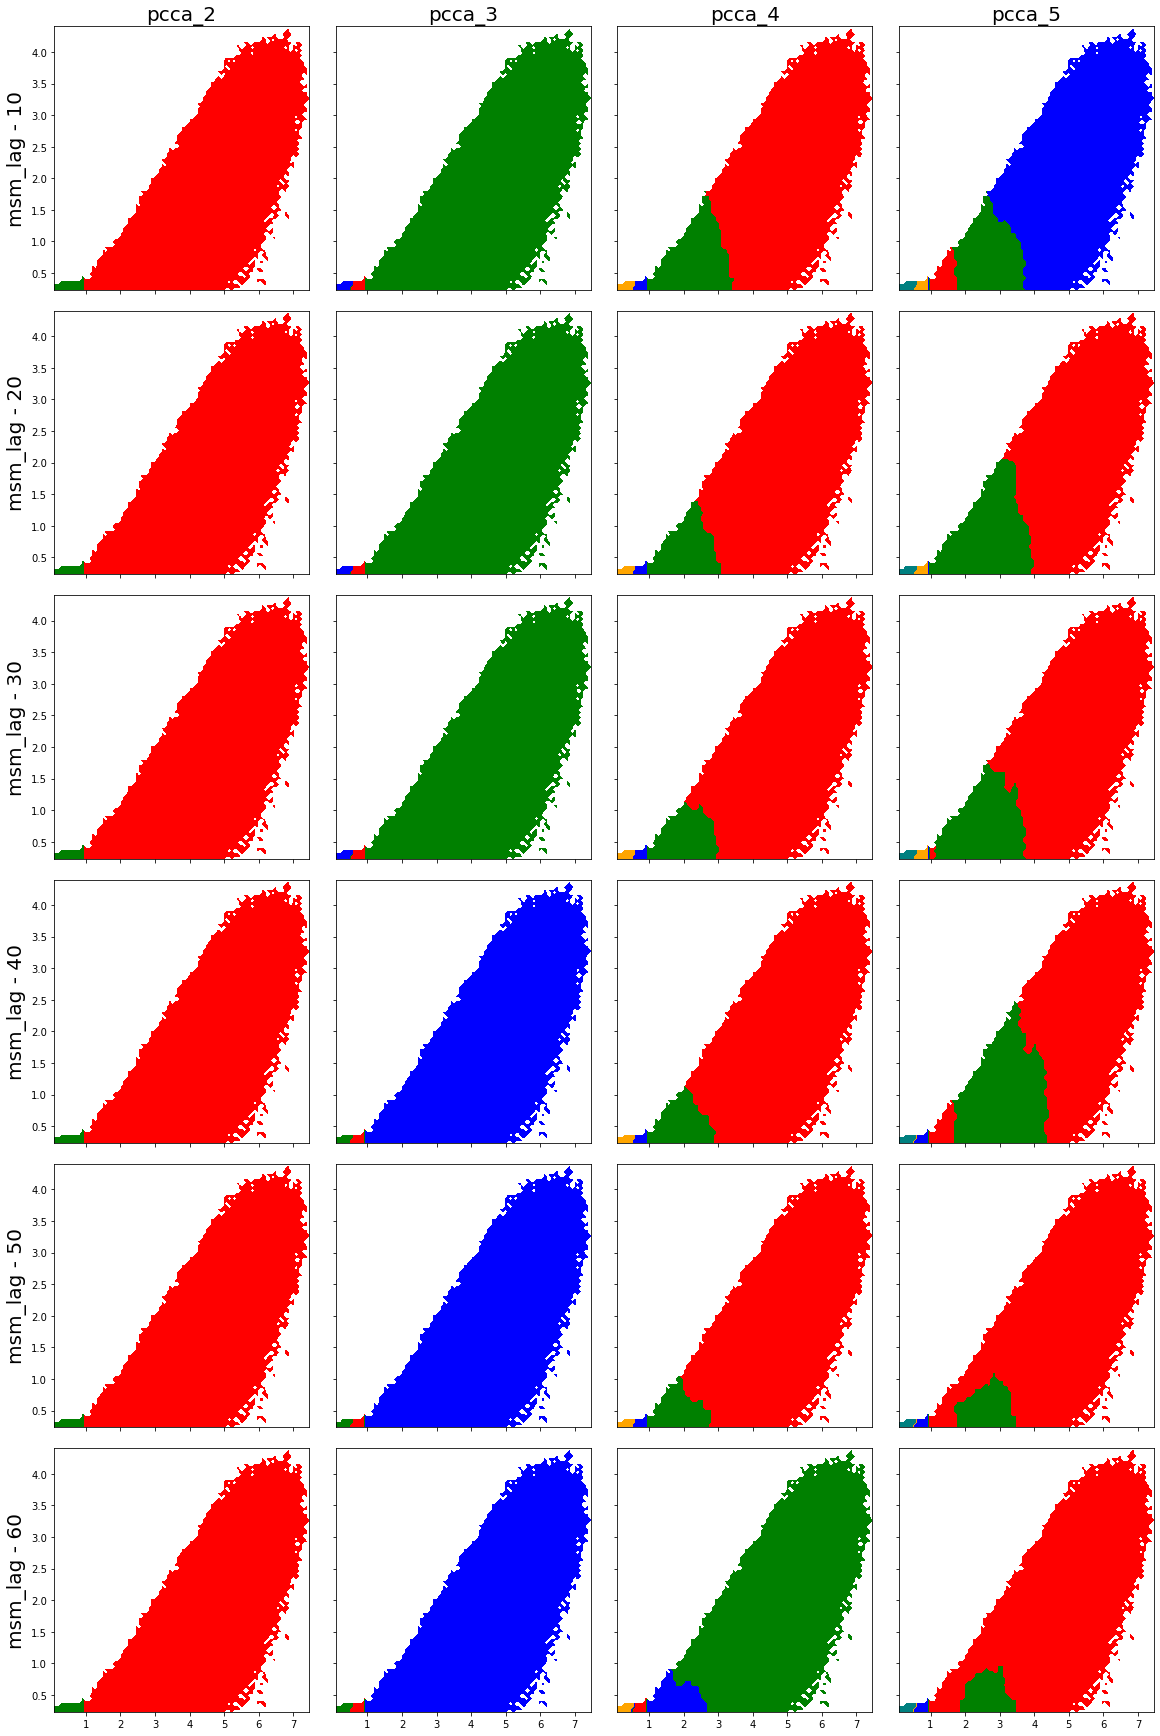

In [35]:
fig,ax = plt.subplots(len(msm_lags), len(mstates), figsize=(4*len(mstates),4*len(msm_lags)), sharex=True, sharey=True)
plt.tight_layout()
for i in range(len(msm_lags)):
    model = msm.estimate_markov_model(dtrajs=list(dtrj_300), lag=msm_lags[i])
    ax[i,0].set_ylabel('msm_lag - {}'.format(msm_lags[i]), fontsize=20)
    for j in range(len(mstates)):
        if i==0: ax[i,j].set_title('pcca_{}'.format(mstates[j]), fontsize=20)
        model.pcca(mstates[j])
        mplt.plot_state_map(np.concatenate((bp)), np.concatenate((mindist)),
                           model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                           ax=ax[i,j], cmap=eval('cmap{}'.format(mstates[j])), cbar=False)
plt.savefig('state_maps.pdf')
plt.show()

(0.1, 4.0)

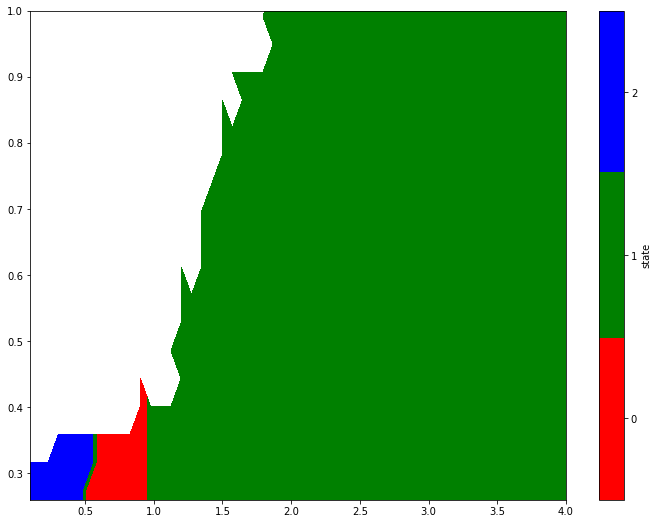

In [41]:
model = msm.estimate_markov_model(list(dtrj_300), lag=20)
model.pcca(3)

fig,ax = plt.subplots(1,figsize=(12,9))
mplt.plot_state_map(np.concatenate((bp)), np.concatenate((mindist)),
                           model.metastable_assignments[np.concatenate((model.dtrajs_active))],
                           ax=ax, cmap=cmap3, cbar=True)
ax.set_ylim(0.26,1)
ax.set_xlim(0.1,4)

In [11]:
populations2 = np.zeros((len(msm_lags), 2))
populations3 = np.zeros((len(msm_lags), 3))
populations4 = np.zeros((len(msm_lags), 4))
for i in range(len(msm_lags)):
    model = msm.estimate_markov_model(list(dtrj_300), lag=msm_lags[i])
    for j in range(len(mstates[:-1])):
        model.pcca(mstates[j])
        for a,b in enumerate(model.metastable_sets):
            eval('populations{}'.format(mstates[j]))[i][a] = model.pi[b].sum()

In [12]:
pd.DataFrame(populations2, index=msm_lags)

,0,1
10,0.397941,0.602059
20,0.397090,0.602910
40,0.395586,0.604414
50,0.394855,0.605145
60,0.394256,0.605744


In [13]:
pd.DataFrame(populations3, index=msm_lags)

,0,1,2
10,0.078748,0.397941,0.523311
20,0.078604,0.397090,0.524306
40,0.078241,0.526173,0.395586
50,0.078065,0.527081,0.394855
60,0.077913,0.527831,0.394256


In [14]:
pd.DataFrame(populations4, index=msm_lags)

,0,1,2,3
10,0.064013,0.333927,0.078748,0.523311
20,0.095510,0.301580,0.078604,0.524306
40,0.134071,0.261515,0.078241,0.526173
50,0.153703,0.241152,0.078065,0.527081
60,0.077913,0.190971,0.203285,0.527831


In [15]:
pocket = ana(dtrj_300)
pocket.take_data(bp)

In [16]:
mean_bp, std_bp, prob_bp = pocket.get_mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.24it/s]


In [17]:
np.argmin(mean_bp)

0

In [18]:
np.argmax(mean_bp)

249

In [19]:
bind = 0
uind = 249
mfpt_2 = np.zeros((len(msm_lags), 2))
mfpt_3 = np.zeros((len(msm_lags), 2))
mfpt_4 = np.zeros((len(msm_lags), 2))

for i in range(len(msm_lags)):
    model = msm.estimate_markov_model(list(dtrj_300), lag=msm_lags[i])
    
    for j in range(len(mstates[:-1])):
        model.pcca(mstates[j])
        
        psets = model.metastable_sets
        for k in psets:
            if bind in k: bound = k
            if uind in k: unbound = k
        
        eval('mfpt_{}'.format(mstates[j]))[i,0] = model.mfpt(unbound,bound) * msm_lags[i] * 10 * 10**(-6)
        eval('mfpt_{}'.format(mstates[j]))[i,1] = model.mfpt(bound,unbound) * msm_lags[i] * 10 * 10**(-6)
        
mfpt_2 = pd.DataFrame(mfpt_2, index=msm_lags, columns=['binding','unbinding'])
mfpt_3 = pd.DataFrame(mfpt_3, index=msm_lags, columns=['binding','unbinding'])
mfpt_4 = pd.DataFrame(mfpt_4, index=msm_lags, columns=['binding','unbinding'])

In [20]:
mfpt_2

,binding,unbinding
10,9.307785,11.608175
20,26.417568,34.282051
40,74.801280,104.940543
50,100.903103,140.800217
60,131.565197,184.164127


In [21]:
mfpt_3

,binding,unbinding
10,11.949246,11.694510
20,34.078020,34.588437
40,97.102760,106.018064
50,129.913328,142.399544
60,168.225978,186.390340


In [22]:
mfpt_4

,binding,unbinding
10,12.068520,18.915654
20,34.354510,53.309188
40,97.729590,151.235052
50,130.717716,202.263151
60,169.190942,261.093108


In [30]:
model = msm.estimate_markov_model(list(dtrj_300), lag=10)
model.pcca(3)

PCCA(P=array([[0.28412, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.11968, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.26718, 0.     ],
       [0.     , 0.     , ..., 0.     , 0.18446]]),
   m=3)

In [31]:
psets = model.metastable_sets
psets

[array([  4,  46, 128, 174, 201, 218, 226, 242]),
 array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
         44,  45,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,
         87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
 

In [32]:
tpt = msm.tpt(model, psets[1], psets[2])

In [33]:
cg, cgflux = tpt.coarse_grain(psets)

In [34]:
path, pathfluxes = cgflux.pathways()

In [35]:
path

[array([0, 1, 2], dtype=int32)]

In [36]:
pathfluxes/np.sum(pathfluxes)

array([1.])

# final - pcca=3, lag=20

# plotting

In [5]:
model300 = msm.estimate_markov_model(list(dtrj_300), lag=20)

In [5]:
kt= 0.617

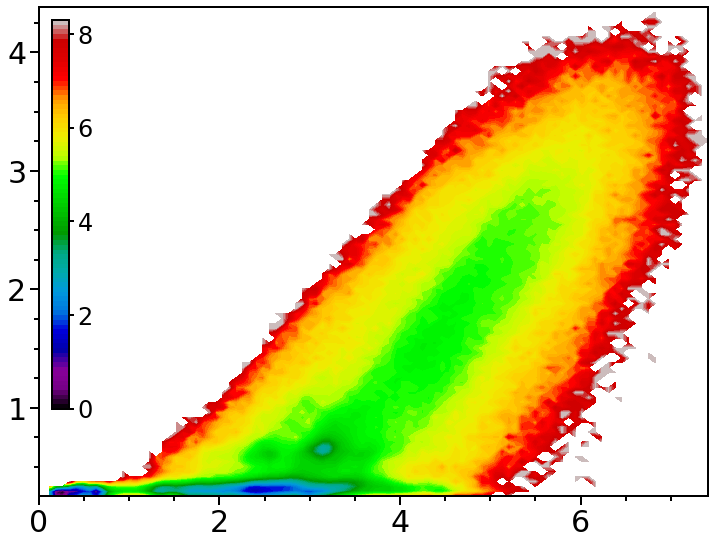

In [66]:
fig, ax = plt.subplots(1, figsize=(12,9))
cax = fig.add_axes([0.14,0.26,0.02,0.6])
mplt.plot_free_energy(np.concatenate((bp)), np.concatenate((mindist)), weights=np.concatenate(model300.trajectory_weights()),
                      ax=ax, cax=cax, kT=kt, cbar_label=None)
ax.tick_params(labelsize=30, length=9, width=2)
cax.tick_params(labelsize=24, length=5, width=2)
ax.spines[:].set_linewidth(2)
cax.spines[:].set_linewidth(2)
cax.set_yticks([0,2,4,6,8])
ax.set_xticks([0,2,4,6])
ax.xaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
ax.yaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
ax.tick_params(which='minor', length=5, width=2)

plt.savefig('weighted_energy_full.pdf')
plt.show()

In [7]:
k = 1.38 * 10**(-23)

In [8]:
na = 6.0223 * 10**23

In [9]:
k * na * 310.5  / 1000 / 4.18

0.6173433796650717

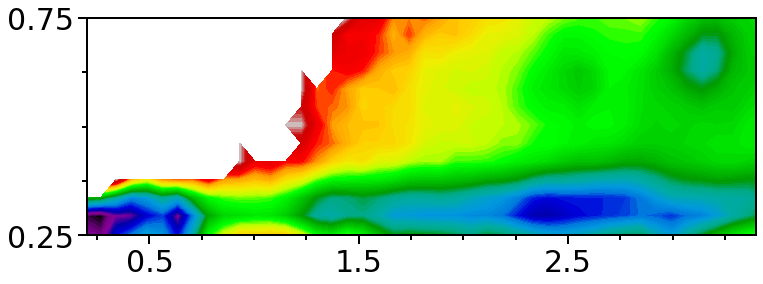

In [64]:
fig, ax = plt.subplots(1, figsize=(12,4))
mplt.plot_free_energy(np.concatenate((bp)), np.concatenate((mindist)), weights=np.concatenate(model300.trajectory_weights()),
                      ax=ax, cbar=False)
ax.tick_params(labelsize=30, length=9, width=2)
ax.spines[:].set_linewidth(2)
ax.set_xlim(0.2,3.4)
ax.set_ylim(0.25,0.75)
ax.set_xticks([0.5,1.5,2.5])
ax.set_yticks([0.25,0.75])
ax.xaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
ax.yaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
ax.tick_params(which='minor', length=5, width=2)

plt.savefig('weighted_energy_zoomed.pdf')
plt.show()

In [6]:
model300.pcca(3)

PCCA(P=array([[2.53232e-01, 0.00000e+00, ..., 0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.03614e-01, ..., 2.01464e-04, 1.99876e-04],
       ...,
       [0.00000e+00, 3.81326e-05, ..., 2.47379e-01, 0.00000e+00],
       [0.00000e+00, 2.80777e-04, ..., 0.00000e+00, 1.46451e-01]]),
   m=3)

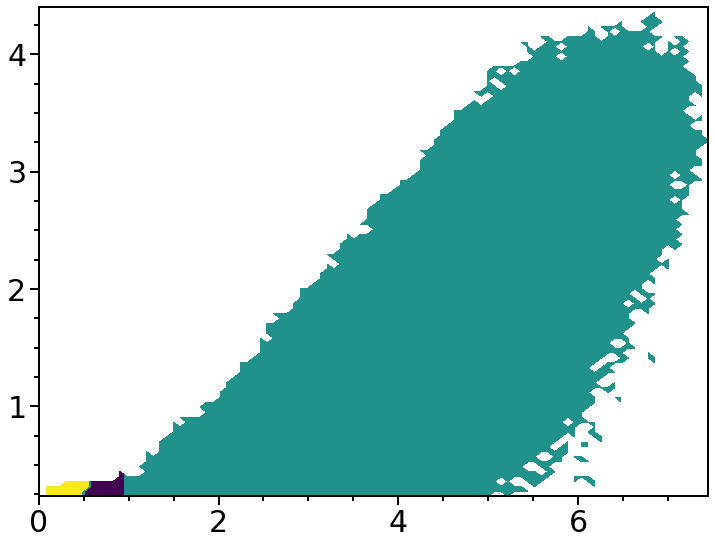

In [77]:
fig, ax = plt.subplots(1, figsize=(12,9))
mplt.plot_state_map( np.concatenate((bp)), np.concatenate((mindist)),
                    model300.metastable_assignments[np.concatenate((model300.dtrajs_active))],
                   ax=ax, cbar=False)
ax.tick_params(labelsize=30, length=9, width=2)
ax.spines[:].set_linewidth(2)
ax.set_xticks([0,2,4,6])
ax.xaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
ax.yaxis.set_minor_locator(m.ticker.AutoMinorLocator(4))
ax.tick_params(which='minor', length=5, width=2)

plt.savefig('state_map_full.pdf')
plt.show()

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x7f87d68c1490>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x7f8780087d90>})

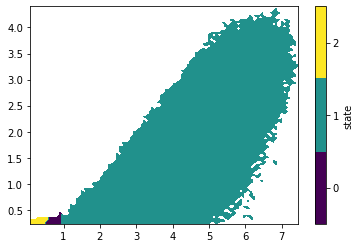

In [12]:
mplt.plot_state_map( np.concatenate((bp)), np.concatenate((mindist)),
                    model300.metastable_assignments[np.concatenate((model300.dtrajs_active))],)


## Bootstrapping

In [122]:
nsize=10
populations = np.zeros((nsize,3))
mfpts = np.zeros((nsize,3))
committors = np.zeros((nsize,3))
bind = 0
uind = 249

for i in range(nsize):
    rant = np.random.randint(dtrj_300.shape[0])
    rans = np.random.random()
    rans = int(np.floor(dtrj_300[rant].shape[0] * rans))
    rand = [-1,1][np.random.randint(0,2)]
    rans = rans * rand
    ndata = c.deepcopy(dtrj_300)
    ndata[rant] = ndata[rant][:rans]
    #
    nmodel = msm.estimate_markov_model(list(ndata), lag=20)
    nmodel.pcca(3)
    #
    for k in range(3):
        if bind in nmodel.metastable_sets[k]: bb=k
        if uind in nmodel.metastable_sets[k]: uu = k
        
    ii = np.setdiff1d([0,1,2],[bb,uu])[0]
    states=[uu,ii,bb]
    combs=[[uu,ii],[uu,bb],[ii,bb]]
    
    for k in range(3):
        populations[i][k] = nmodel.pi[nmodel.metastable_sets[states[k]]].sum()
        mfpts[i][k] = nmodel.mfpt(nmodel.metastable_sets[combs[k][0]], nmodel.metastable_sets[combs[k][1]]) * 20 * 10 * 10**(-6)
        
    tpt = msm.tpt(nmodel, nmodel.metastable_sets[uu], nmodel.metastable_sets[bb])
    cg, cgflux = tpt.coarse_grain(nmodel.metastable_sets)
    committors[i] = cgflux.committor

In [123]:
np.savetxt('populations.txt',populations)
np.savetxt('mfpts.txt', mfpts)
np.savetxt('committors.txt', committors)

In [124]:
committors

array([[0.        , 0.94167732, 1.        ],
       [0.        , 0.95733658, 1.        ],
       [0.        , 0.94177287, 1.        ],
       [0.        , 0.94061118, 1.        ],
       [0.        , 0.94177288, 1.        ],
       [0.        , 0.94177288, 1.        ],
       [0.        , 0.96277228, 1.        ],
       [0.        , 0.95045833, 1.        ],
       [0.        , 0.94177136, 1.        ],
       [0.        , 0.94177287, 1.        ]])

In [125]:
np.mean(committors, axis=0)

array([0.        , 0.94617186, 1.        ])

In [126]:
np.std(committors, axis=0)

array([0.00000000e+00, 7.52654831e-03, 1.16441173e-16])

In [94]:
mfpts

array([[26.41756838, 34.07829835,  1.55852228],
       [26.41756822, 34.08597243,  1.5663144 ],
       [26.41756867, 34.10548251,  1.58615506],
       [26.41756845, 34.07802048,  1.55823777],
       [30.23215701, 35.82707323,  1.38296022],
       [26.4175678 , 34.08367384,  1.56398725],
       [26.41756858, 34.0780207 ,  1.55823776],
       [24.96408875, 32.14282851,  1.47271185],
       [26.4175711 , 34.14488243,  1.60590276],
       [26.41756838, 34.07802038,  1.55823777]])

In [98]:
np.mean(mfpts, axis=0)

array([26.65367953, 34.07022729,  1.54112671])

In [99]:
np.std(mfpts, axis=0)

array([1.26910223, 0.82515854, 0.06185363])

In [28]:
side = 8.68 #nm
nmol=4
conc = (1.66 * nmol ) / side**3
conc

0.01015333940152352

In [29]:
kon = 1 / (34.07 * 10**(-6) * conc)
kon

2890806.1008342146

In [31]:
kon/1e+6

2.8908061008342147

## 2.89 +- 0.83 M-1s-1

In [32]:
psets

[array([  4,  46, 128, 174, 201, 218, 226, 242]),
 array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
         44,  45,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,
         87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
 

In [35]:
model300.mfpt(psets[0], psets[1]) * 20 * 10 * 10**(-6)

32.238378724460944

<center>
    <font size=6>
        <br><br>
        A -> B -> C <br><br>
        $ t_{AB} * com_B - t_{BA} * (1-com_B) + t_{BC} = t_{AC}    $
        <br><br><br>
    </font>
</center>

In [36]:
34 - (26 * 0.94) + (32 * (1-0.94)) 

11.480000000000004

### markov model

In [7]:
dd = model300.metastable_assignments[np.concatenate((model300.dtrajs_active))]
mdtrj = []
k=0
for i in range(len(dtrj_300)):
    di=[]
    for j in range(len(dtrj_300[i])):
        di.append(dd[k])
        k += 1
    mdtrj.append(di)

In [8]:
metastable_model = msm.estimate_markov_model(mdtrj, lag=20)

In [13]:
mdis = model300.metastable_sets
mdis

[array([  4,  46, 128, 174, 201, 218, 226, 242]),
 array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
         44,  45,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,
         87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
 

In [14]:
metastable_model.mfpt([1], [2]) * 20 * 10 * 10**(-6)

16.45068173612509

In [15]:
metastable_model.mfpt([1], [0]) * 20 * 10 * 10**(-6)

15.324735169453593

In [16]:
metastable_model.mfpt([0], [2]) * 20 * 10 * 10**(-6)

1.125946566671591

### binding energy

In [23]:
dd=np.loadtxt('populations.txt')
print(np.mean(dd,axis=0))
print(np.std(dd,axis=0))

[0.39611187 0.08078675 0.52310138]
[0.02032621 0.0024804  0.02135163]


In [25]:
-0.61*np.log(0.523/(0.396**2)) # kt * log ([PL] / [P][L]) assuming [P] == [L]

-0.7347500755282403

In [29]:
-0.735 - 0.61 * np.log( (8.6**3)/1661 )

-0.14946801510070562

In [66]:
positions = np.array([
    [1,1], [0,0], [2,2]
])
names = ['I', 'U', 'B']
colors=['green', 'cyan', 'red']

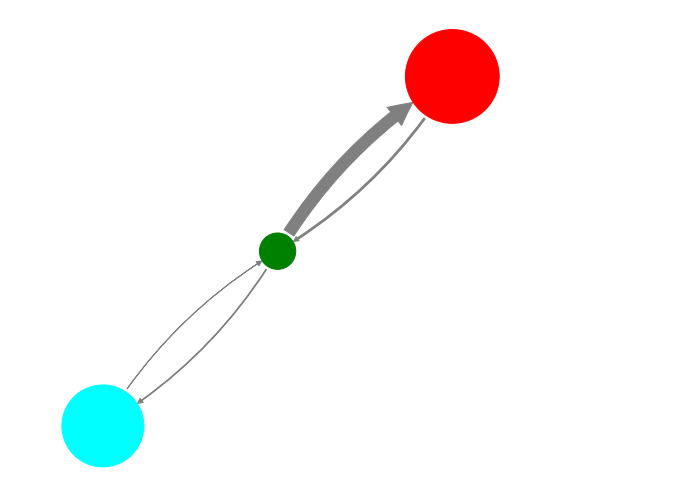

In [67]:
fig,ax = plt.subplots(figsize=(12,9))
mplt.plot_markov_model(metastable_model, ax=ax,
                      pos=positions, state_labels=None, size=28, 
                       arrow_labels=None, arrow_scale=2, state_scale=0.6, state_colors=colors)
plt.savefig('pathway.pdf')
plt.show()

In [19]:
hmodel300 = msm.estimate_hidden_markov_model(list(dtrj_300), nstates=3, lag=20)

In [26]:
hmodel300.metastable_sets

[array([  4,  12,  46,  49,  84, 103, 128, 146, 174, 185, 201, 209, 218,
        226, 242, 268, 292]),
 array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
         44,  45,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,
         87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 175, 176

In [27]:
psets

[array([  4,  46, 128, 174, 201, 218, 226, 242]),
 array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  14,  15,  16,
         17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
         30,  31,  32,  33,  34,  35,  36,  37,  39,  40,  41,  42,  43,
         44,  45,  47,  48,  50,  51,  52,  53,  54,  55,  56,  57,  58,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
         73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  85,  86,
         87,  88,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
        101, 102, 104, 105, 106, 107, 108, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 127, 129, 130,
        131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144,
        147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
 

In [25]:
hmodel300.lifetimes * 20 * 10 * 10**(-6)

array([  1.89226387, 102.36076564,   4.81554341])

## lifetimes notmaking sense
## also, metastable distribution of hmm is different from normal

## metastable dtraj

In [37]:
def get_mdtrj(dtrj, mdis, output_type='concated'):
    '''
    this function manually creates metastable dtrj(mdis) based of metastable distributions (mdis, pcca output or eq), 
    given a normal dtrja(dtrj, microstates)
    '''
#     if np.max(dtrj) != np.max(mdis): raise ValueError()
    cdtrj = np.concatenate((dtrj))
    mdtrj = cp.deepcopy(cdtrj)
    for i in range(len(mdis)):
        for j in mdis[i]:
            mdtrj[ np.where( cdtrj == j )[0] ] = i

    if output_type == 'concated':
        return mdtrj
    elif output_type == 'trj':
        k=0
        fdtrj = cp.deepcopy(dtrj)
        for i in range(len(dtrj)):
            for j in range(len(dtrj[i])):
                fdtrj[i][j] = mdtrj[k]
                k = k+1
        return fdtrj
    else:
        return ValueError('output_type E [concated, trj]')

In [38]:
msm_lags = [10,20,30,40,50,60]
mstates = [2,3,4,5]

In [33]:

for i in range(len(msm_lags)):
    
    for j in range(len(mstates)):
        
        model = msm.estimate_markov_model( dtrajs=list(dtrj_300), lag=msm_lags[i] )
        model.pcca(mstates[j])
        mdis = model.metastable_sets
        mdtrj = get_mdtrj(dtrj_300, mdis, output_type='trj')
        
        np.save(f'saved_mdtrj/mdtrj_300_lag{msm_lags[i]}_pcca{mstates[j]}.npy', mdtrj, allow_pickle=True)

## 4th state of 4 pcca model

In [8]:
model = msm.estimate_markov_model(list(dtrj_300), lag=10)

In [9]:
model.pcca(4)

PCCA(P=array([[0.28412, 0.     , ..., 0.     , 0.     ],
       [0.     , 0.11968, ..., 0.     , 0.     ],
       ...,
       [0.     , 0.     , ..., 0.26718, 0.     ],
       [0.     , 0.     , ..., 0.     , 0.18446]]),
   m=4)

In [29]:
mdis=model.metastable_sets
mdis

[array([  2,   5,   6,   9,  10,  11,  16,  17,  18,  20,  23,  24,  26,
         28,  30,  32,  33,  34,  35,  36,  37,  39,  41,  42,  44,  45,
         47,  48,  52,  55,  57,  58,  61,  62,  63,  64,  67,  68,  69,
         70,  71,  74,  76,  77,  78,  80,  81,  82,  83,  85,  86,  87,
         88,  91,  92,  93,  94,  95,  98,  99, 100, 101, 102, 104, 106,
        108, 110, 112, 113, 115, 116, 117, 118, 124, 125, 127, 130, 131,
        132, 134, 135, 136, 139, 140, 141, 142, 144, 148, 149, 151, 152,
        153, 154, 155, 158, 159, 161, 164, 165, 166, 169, 170, 172, 175,
        177, 178, 182, 183, 184, 186, 187, 188, 189, 191, 193, 195, 196,
        197, 200, 202, 203, 206, 208, 210, 211, 213, 214, 217, 220, 221,
        222, 225, 227, 229, 231, 232, 234, 235, 236, 238, 240, 243, 244,
        247, 249, 250, 252, 253, 254, 255, 256, 257, 259, 261, 262, 263,
        264, 267, 269, 273, 274, 276, 277, 278, 280, 282, 283, 284, 285,
        286, 287, 289, 290, 291, 293, 294, 297, 299

In [18]:
dd = model.metastable_assignments[np.concatenate((model.dtrajs_active))]
mdtrj = []
k=0
for i in range(len(dtrj_300)):
    di=[]
    for j in range(len(dtrj_300[i])):
        di.append(dd[k])
        k += 1
    mdtrj.append(np.array(di))

In [27]:
a1 = ana(dtrj_300)
a1.take_data(bp)
m1 = a1.get_mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


In [28]:
a2 = ana(dtrj_300)
a2.take_data(mindist)
m2 = a2.get_mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:09<00:00,  3.20it/s]


In [44]:
colors=['salmon', 'dodgerblue', 'blue', 'forestgreen']
cmap = np.zeros((300)).astype(str)
for i in range(len(colors)):
    cmap[mdis[i]] = colors[i]

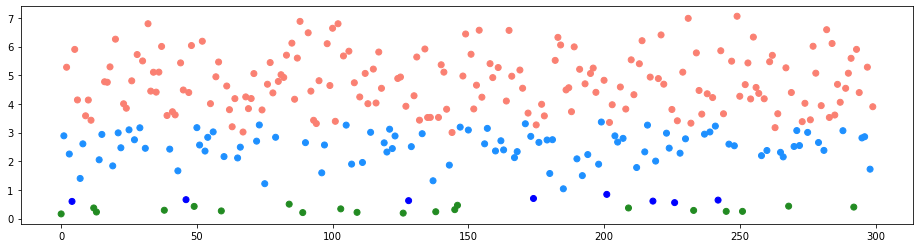

In [45]:
fig,ax=plt.subplots(1, figsize=(16,4))
ax.scatter(range(300), m1[0], c=cmap)

In [47]:
for a,i in enumerate(mdtrj):
    print(a,np.where(i==1)[0].shape[0]/i.shape[0])

0 0.0
1 0.0
2 0.0
3 0.0
4 0.42027771538384745
5 0.4139089652275869
6 0.8128760469346553
7 0.8133809330953345
8 0.8347858260708696
9 0.9053904730476348
10 0.8823105884470578
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0994900509949005
24 0.0
25 0.0
26 0.0
27 0.0
28 9.999000099990002e-05
29 0.0
30 0.0


In [49]:
np.where(mdtrj[4]==1)[0].shape

(269435,)

In [56]:
inds = np.where(mdtrj[4]==1)[0][::5000]
inds.shape

(54,)

In [59]:
u4 = mda.Universe('../../1_contact_metrics/1_data1/0_trajs/prlig.pdb',
                 '../../1_contact_metrics/1_data1/0_trajs/closed_13.xtc')

In [63]:
for a,i in enumerate(inds):
    u4.trajectory[i]
    u4.atoms.write(f'saved_4th_state/{a}.pdb')

/home/jayakrishnak/softwares/anaconda/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1151: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
/home/jayakrishnak/softwares/anaconda/lib/python3.9/site-packages/MDAnalysis/coordinates/PDB.py:1198: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."
